# Training History Plots

This notebook loads a training history `.npz` file (created by the training scripts) and produces:
1. A loss curve (train vs validation)
2. Violin plots for the 4 target RMSE values across epochs (Teff, logg, [Fe/H], [a/Fe])

Edit the `HISTORY_PATH` variable in the code cell below to point to your `.history.npz` file (for example `../pytorch_models/new_mlp_model.history.npz`).

In [ ]:
# Cell 1: Load history file
%matplotlib inline
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Path to the .npz history file - edit this if needed
HISTORY_PATH = Path('../pytorch_models/new_mlp_model.history.npz')

if not HISTORY_PATH.exists():
    raise FileNotFoundError(f'History file not found: {HISTORY_PATH}')

data = np.load(HISTORY_PATH, allow_pickle=True)
print('Loaded keys:', list(data.keys()))

train_loss = data['train_loss']
val_loss = data['val_loss']

print(f'train_loss shape: {train_loss.shape}')
print(f'val_loss shape: {val_loss.shape}')

Loaded keys: ['train_loss', 'val_loss', 'val_rmse']
train_loss shape: (10,)
val_loss shape: (10,)


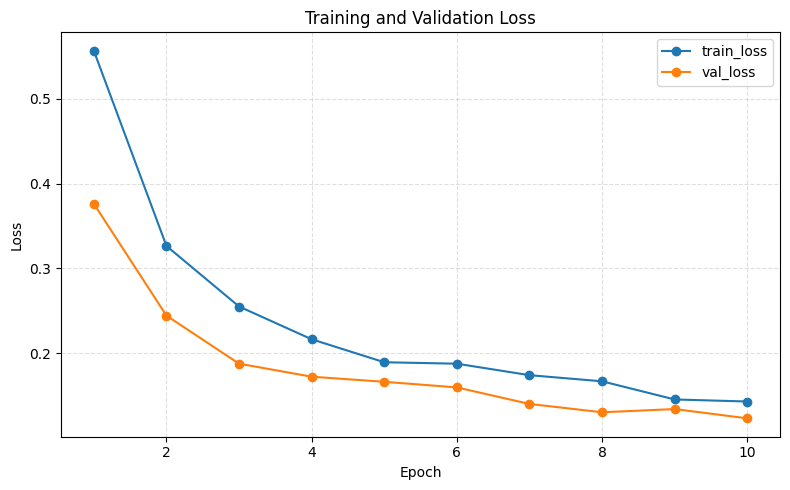

In [ ]:
# Cell 2: Plot loss curves (train vs validation)
fig, ax = plt.subplots(figsize=(8, 5))
epochs = np.arange(1, len(train_loss) + 1)
ax.plot(epochs, train_loss, marker='o', label='train_loss')
ax.plot(epochs, val_loss, marker='o', label='val_loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
#out_path = Path('loss_curve.png')
#fig.savefig(out_path, dpi=150)
#print(f'Saved loss curve to {out_path}')
plt.show()

In [9]:
# Cell: Ensure the project root is on sys.path so local imports work in the notebook
import sys
# The notebook lives in `results/` so the project root is one level up ('..').
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))
print('Added project root to sys.path:', project_root)
# Optional: show the first entry to confirm
print('sys.path[0]=', sys.path[0])

Added project root to sys.path: /lustre06/project/6016730/minjihk/WEAVE_Pristine
sys.path[0]= /lustre06/project/6016730/minjihk/WEAVE_Pristine


In [10]:
import torch

MODEL_PTH = Path('../pytorch_models/new_mlp_model.pth')  # adjust path if needed
device = 'cpu'  # or 'cuda'

# Load checkpoint (if not loaded already)
if 'ckpt' not in globals():
    # If you previously used safe_globals, keep that approach. Here we just attempt a normal load:
    ckpt = torch.load(MODEL_PTH, map_location=device, weights_only=False)

# Extract the state_dict (the saved model parameters)
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    saved_state = ckpt['model_state_dict']
else:
    saved_state = ckpt  # assume ckpt is a state_dict

# Inspect top-level prefixes
prefixes = set(name.split('.')[0] for name in saved_state.keys())
print("Top-level parameter prefixes in checkpoint:", prefixes)

# Try to import both MLP implementations
MLP_class_choice = None
try:
    from pytorch_models.MLP import MLP as MLP_network_class
except Exception as e:
    MLP_network_class = None
    # print("Could not import pytorch_models.MLP:", e)

try:
    from pytorch_models.new_MLP import MLP as MLP_linear_class
except Exception as e:
    MLP_linear_class = None
    # print("Could not import pytorch_models.new_MLP:", e)

# Decide which class to instantiate based on checkpoint keys
if 'linear_relu_stack' in prefixes and MLP_linear_class is not None:
    MLP_class_choice = MLP_linear_class
    print("Using MLP class from pytorch_models.new_MLP (matches 'linear_relu_stack' prefix).")
elif 'network' in prefixes and MLP_network_class is not None:
    MLP_class_choice = MLP_network_class
    print("Using MLP class from pytorch_models.MLP (matches 'network' prefix).")
else:
    # Fallback heuristics
    if MLP_linear_class is not None:
        MLP_class_choice = MLP_linear_class
        print("Warning: couldn't find explicit prefix match; falling back to new_MLP.MLP")
    elif MLP_network_class is not None:
        MLP_class_choice = MLP_network_class
        print("Warning: couldn't find explicit prefix match; falling back to MLP.MLP")
    else:
        raise ImportError("No MLP class available to load the state_dict into.")

# Use saved metadata if available
hidden_layers = None
input_size = None
output_size = None
if isinstance(ckpt, dict):
    hidden_layers = ckpt.get('hidden_layers', None)
    input_size = ckpt.get('input_size', None)
    output_size = ckpt.get('output_size', None)

# If no metadata, try to infer from saved_state shapes (best-effort) or fall back to dataset values if present
# Here we prefer saved metadata; otherwise adjust manually.
print("Saved metadata: hidden_layers =", hidden_layers, "input_size =", input_size, "output_size =", output_size)

# Instantiate model with available metadata (provide sensible defaults if needed)
if hidden_layers is not None:
    try:
        model = MLP_class_choice(input_size=input_size or 0, output_size=output_size or 0, hidden_layers=hidden_layers)
    except TypeError:
        # Some MLP constructors may not accept hidden_layers in that position - try alternative call
        model = MLP_class_choice(input_size=input_size or 0, output_size=output_size or 0)
else:
    # fallback: instantiate with input/output if available, else use defaults
    kwargs = {}
    if input_size is not None:
        kwargs['input_size'] = input_size
    if output_size is not None:
        kwargs['output_size'] = output_size
    model = MLP_class_choice(**kwargs) if kwargs else MLP_class_choice(input_size= (input_size or 1), output_size=(output_size or 1))

# Attempt strict load first
try:
    model.load_state_dict(saved_state, strict=True)
    print("State dict loaded with strict=True (exact match).")
except RuntimeError as e:
    print("Strict load failed, will retry with strict=False to allow prefix/structure differences.")
    print("Strict load error:", e)
    load_result = model.load_state_dict(saved_state, strict=False)
    # load_result is an _IncompatibleKeys object; print missing/unexpected keys
    missing = getattr(load_result, 'missing_keys', None)
    unexpected = getattr(load_result, 'unexpected_keys', None)
    print("Missing keys (expected by model but not in checkpoint):", missing)
    print("Unexpected keys (in checkpoint but not used by model):", unexpected)
    print("State dict loaded with strict=False (some keys ignored).")

# Move model to device if needed
model.to(device)
print("Model ready. You can now run evaluation on the validation set.")

Top-level parameter prefixes in checkpoint: {'linear_relu_stack'}
Using MLP class from pytorch_models.new_MLP (matches 'linear_relu_stack' prefix).
Saved metadata: hidden_layers = [1024, 512] input_size = 6487 output_size = 4
Using MLP class from pytorch_models.new_MLP (matches 'linear_relu_stack' prefix).
Saved metadata: hidden_layers = [1024, 512] input_size = 6487 output_size = 4
State dict loaded with strict=True (exact match).
Model ready. You can now run evaluation on the validation set.
State dict loaded with strict=True (exact match).
Model ready. You can now run evaluation on the validation set.


In [13]:
# Create or obtain a validation DataLoader (val_loader) for evaluation
import sys
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

# Ensure project root is on sys.path
project_root = Path('..').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Path to HDF5 (adjust if needed)
HDF5_PATH = Path('../data/processed_spectra.h5')

val_loader = None
dataloaders = None
dataset = None

try:
    # Try to import the project's Dataset + helper
    from pytorch_models.spectral_dataset import SpectralDataset, create_spectral_dataloaders, SpectralTransforms
    print('Imported create_spectral_dataloaders from pytorch_models.spectral_dataset')

    # Instantiate dataset (match how training did it; adjust args if your training used different ones)
    dataset = SpectralDataset(
        hdf5_filepath=HDF5_PATH,
        load_targets=True,
        target_key='original_stellar_parameters',
        use_target_indices=[0, 1, 2, 3],
        transform=SpectralTransforms.standardize,
        device='cpu'
    )

    # Create dataloaders using the project's helper (will return train, val, ...)
    dataloaders = create_spectral_dataloaders(
        dataset,
        batch_size=64,
        train_split=0.8,
        val_split=0.2,
        random_seed=42
    )

    # pick validation loader
    if isinstance(dataloaders, (list, tuple)) and len(dataloaders) > 1:
        val_loader = dataloaders[1]
    elif isinstance(dataloaders, dict):
        val_loader = dataloaders.get('val') or dataloaders.get('validation') or next(iter(dataloaders.values()))
    else:
        val_loader = dataloaders

    print('Created dataloaders via helper; validation batch count =', len(val_loader))

except Exception as e:
    # Fallback: manual deterministic split and DataLoader creation
    print('Helper import/creation failed or not available, falling back to manual split. Error:', e)

    # Import dataset class directly if available
    try:
        from pytorch_models.spectral_dataset import SpectralDataset, SpectralTransforms
        dataset = SpectralDataset(
            hdf5_filepath=HDF5_PATH,
            load_targets=True,
            target_key='original_stellar_parameters',
            use_target_indices=[0, 1, 2, 3],
            transform=SpectralTransforms.standardize,
            device='cpu'
        )
    except Exception as e2:
        raise RuntimeError('Could not import or instantiate dataset. Check your project imports and HDF5 path.') from e2

    # Deterministic split: shuffle with fixed seed then slice
    n = len(dataset)
    indices = np.arange(n)
    rng = np.random.RandomState(42)
    rng.shuffle(indices)
    split = int(0.8 * n)
    train_idx = indices[:split]
    val_idx = indices[split:]

    val_subset = Subset(dataset, val_idx)
    # ensure shuffle=False for val loader to keep stable ordering
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
    dataloaders = (None, val_loader)
    print('Created manual val_loader; val size =', len(val_subset))

# Expose globally for subsequent cells
globals()['val_loader'] = val_loader
globals()['dataloaders'] = dataloaders
globals()['dataset'] = dataset

print('\nValidation DataLoader ready.')
print('val_loader length (batches) =', len(val_loader))
try:
    # show example batch shapes / keys
    batch = next(iter(val_loader))
    if isinstance(batch, (list, tuple)):
        print('Example batch -> inputs shape:', getattr(batch[0], 'shape', type(batch[0])), ', targets shape:', getattr(batch[1], 'shape', type(batch[1])))
        if len(batch) >= 3:
            print('Third element in batch (indices) type/shape:', type(batch[2]), getattr(batch[2], 'shape', 'scalar or list'))
    elif isinstance(batch, dict):
        print('Example dict batch keys:', list(batch.keys()))
    else:
        print('Example batch type:', type(batch))
except Exception as e:
    print('Could not inspect example batch:', e)

Imported create_spectral_dataloaders from pytorch_models.spectral_dataset
Data validation passed
SpectralDataset initialized:
  File: ../data/processed_spectra.h5
  Spectra: 971
  Wavelength points: 6487
  Wavelength range: 4851.92 - 4885.00 Å
  Flux key: flux_normalized
  Load targets: True
  Target key: original_stellar_parameters
  Using target indices: [0, 1, 2, 3]
  Device: cpu
Creating DataLoaders:
  Total dataset size: 971
  Train size: 776
  Validation size: 194
  Test size: 1
  Batch size: 64
  Train DataLoader: 12 batches
  Val DataLoader: 4 batches
  Test DataLoader: 1 batches
Created dataloaders via helper; validation batch count = 4

Validation DataLoader ready.
val_loader length (batches) = 4
Example batch -> inputs shape: torch.Size([64, 6487]) , targets shape: torch.Size([64, 4])
Example batch -> inputs shape: torch.Size([64, 6487]) , targets shape: torch.Size([64, 4])


In [16]:
# Create or obtain a validation DataLoader (val_loader) for evaluation — fixed call to create_spectral_dataloaders(dataset, ...)
import sys
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

# Ensure project root is on sys.path
project_root = Path('..').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Path to HDF5 (adjust if needed)
HDF5_PATH = Path('../data/processed_spectra.h5')

val_loader = None
dataloaders = None
dataset = globals().get('dataset', None)  # reuse if already created

try:
    # Import the project's Dataset + helper
    from pytorch_models.spectral_dataset import SpectralDataset, create_spectral_dataloaders, SpectralTransforms
    print('Imported create_spectral_dataloaders from pytorch_models.spectral_dataset')

    # Instantiate dataset if not present
    if dataset is None:
        dataset = SpectralDataset(
            hdf5_filepath=HDF5_PATH,
            load_targets=True,
            target_key='original_stellar_parameters',
            use_target_indices=[0, 1, 2, 3],
            transform=SpectralTransforms.standardize,
            device='cpu'
        )
        print('Instantiated SpectralDataset')

    # Call helper with the dataset argument (the function requires dataset)
    dataloaders = create_spectral_dataloaders(
        dataset,
        batch_size=64,
        train_split=0.8,
        val_split=0.2,
        random_seed=42
    )

    # pick validation loader
    if isinstance(dataloaders, (list, tuple)) and len(dataloaders) > 1:
        val_loader = dataloaders[1]
    elif isinstance(dataloaders, dict):
        val_loader = dataloaders.get('val') or dataloaders.get('validation') or next(iter(dataloaders.values()))
    else:
        val_loader = dataloaders

    print('Created dataloaders via helper; validation batch count =', len(val_loader))

except Exception as e:
    # Fallback: manual deterministic split and DataLoader creation
    print('Helper call failed; falling back to manual split. Error:', e)

    # If dataset is still None try to import/instantiate it
    if dataset is None:
        try:
            from pytorch_models.spectral_dataset import SpectralDataset, SpectralTransforms
            dataset = SpectralDataset(
                hdf5_filepath=HDF5_PATH,
                load_targets=True,
                target_key='original_stellar_parameters',
                use_target_indices=[0, 1, 2, 3],
                transform=SpectralTransforms.standardize,
                device='cpu'
            )
            print('Instantiated SpectralDataset in fallback branch')
        except Exception as e2:
            raise RuntimeError('Could not import or instantiate dataset. Check your project imports and HDF5 path.') from e2

    # Deterministic split: shuffle with fixed seed then slice
    n = len(dataset)
    indices = np.arange(n)
    rng = np.random.RandomState(42)
    rng.shuffle(indices)
    split = int(0.8 * n)
    train_idx = indices[:split]
    val_idx = indices[split:]

    val_subset = Subset(dataset, val_idx)
    # ensure shuffle=False for val loader to keep stable ordering
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
    dataloaders = (None, val_loader)
    print('Created manual val_loader; val size =', len(val_subset))

# Expose globally for subsequent cells
globals()['val_loader'] = val_loader
globals()['dataloaders'] = dataloaders
globals()['dataset'] = dataset

print('\nValidation DataLoader ready.')
print('val_loader length (batches) =', len(val_loader))
try:
    # show example batch shapes / keys
    batch = next(iter(val_loader))
    if isinstance(batch, (list, tuple)):
        print('Example batch -> inputs shape:', getattr(batch[0], 'shape', type(batch[0])), ', targets shape:', getattr(batch[1], 'shape', type(batch[1])))
        if len(batch) >= 3:
            print('Third element in batch (indices) type/shape:', type(batch[2]), getattr(batch[2], 'shape', 'scalar or list'))
    elif isinstance(batch, dict):
        print('Example dict batch keys:', list(batch.keys()))
    else:
        print('Example batch type:', type(batch))
except Exception as e:
    print('Could not inspect example batch:', e)

Imported create_spectral_dataloaders from pytorch_models.spectral_dataset
Creating DataLoaders:
  Total dataset size: 971
  Train size: 776
  Validation size: 194
  Test size: 1
  Batch size: 64
  Train DataLoader: 12 batches
  Val DataLoader: 4 batches
  Test DataLoader: 1 batches
Created dataloaders via helper; validation batch count = 4

Validation DataLoader ready.
val_loader length (batches) = 4
Example batch -> inputs shape: torch.Size([64, 6487]) , targets shape: torch.Size([64, 4])
Example batch -> inputs shape: torch.Size([64, 6487]) , targets shape: torch.Size([64, 4])


In [20]:
# Compute predictions on validation set, map them to original indices, compute residuals, save and expose globals.
import torch
import numpy as np
from pathlib import Path

OUT_DIR = Path('../results')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Checks
if 'model' not in globals():
    raise RuntimeError("No `model` in globals. Run the model-loading cell first.")
if 'val_loader' not in globals():
    raise RuntimeError("No `val_loader` in globals. Create or load a validation DataLoader first.")

model = globals()['model']
val_loader = globals()['val_loader']
device = globals().get('device', 'cpu')
model = model.to(device)
model.eval()

pred_chunks = []
truth_chunks = []
index_chunks = []
collected_indices = False

with torch.no_grad():
    for batch in val_loader:
        # Accept common batch formats:
        # (inputs, targets), (inputs, targets, indices), dict batches
        if isinstance(batch, dict):
            inputs = batch.get('inputs') or batch.get('spectra') or batch.get('x') or batch.get('data')
            targets = batch.get('targets') or batch.get('y') or batch.get('labels')
            batch_idx = batch.get('indices') or batch.get('idx') or batch.get('index')
        elif isinstance(batch, (list, tuple)):
            if len(batch) == 2:
                inputs, targets = batch
                batch_idx = None
            elif len(batch) >= 3:
                inputs, targets, batch_idx = batch[0], batch[1], batch[2]
            else:
                raise RuntimeError("Unexpected batch tuple format from dataloader")
        else:
            raise RuntimeError(f"Unrecognized batch type from dataloader: {type(batch)}")

        # Convert numpy -> tensor if needed
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs)
        if isinstance(targets, np.ndarray):
            targets = torch.from_numpy(targets)

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        pred_chunks.append(outputs.cpu())
        truth_chunks.append(targets.cpu())

        # Collect batch indices if provided by the dataloader
        if 'batch_idx' in locals() and batch_idx is not None:
            collected_indices = True
            if isinstance(batch_idx, torch.Tensor):
                index_chunks.append(batch_idx.cpu().numpy())
            elif isinstance(batch_idx, (list, np.ndarray)):
                index_chunks.append(np.array(batch_idx))
            else:
                index_chunks.append(np.array([batch_idx]))

# Concatenate predictions/truths
preds = np.concatenate([p.numpy() if isinstance(p, torch.Tensor) else np.array(p) for p in pred_chunks], axis=0)
truths = np.concatenate([t.numpy() if isinstance(t, torch.Tensor) else np.array(t) for t in truth_chunks], axis=0)

# Determine indices -> which spectrum each row corresponds to
if collected_indices and len(index_chunks) > 0:
    indices = np.concatenate(index_chunks, axis=0)
    print("Collected explicit batch indices from the dataloader.")
else:
    # If the val_loader.dataset is a Subset it likely stores original indices
    dataset_obj = getattr(val_loader, 'dataset', None)
    if dataset_obj is not None and hasattr(dataset_obj, 'indices'):
        indices = np.array(dataset_obj.indices)
        print("Using dataset.indices from Subset.")
    else:
        # fallback: sequential mapping (ensure val_loader was created with shuffle=False)
        indices = np.arange(len(preds))
        print("No explicit indices found; using sequential 0..N-1 mapping. Ensure val_loader was created with shuffle=False.")

# Sanity check
if not (len(indices) == preds.shape[0] == truths.shape[0]):
    raise RuntimeError(f"Length mismatch: indices={len(indices)}, preds={preds.shape[0]}, truths={truths.shape[0]}")

# Helper: inverse-transform to physical units
def _inverse_targets_np(arr_np):
    # 1) If dataset provides inverse_transform_target, use it
    ds = getattr(val_loader, 'dataset', None)
    if ds is not None and hasattr(ds, 'inverse_transform_target'):
        try:
            return ds.inverse_transform_target(torch.from_numpy(arr_np)).cpu().numpy()
        except Exception:
            # fallback to np-scale below
            pass
    # 2) If checkpoint contains mean/std, use that
    if 'ckpt' in globals() and isinstance(globals()['ckpt'], dict):
        ck = globals()['ckpt']
        mean = ck.get('target_mean', None)
        std = ck.get('target_std', None)
        if mean is not None and std is not None:
            mean = np.array(mean)
            std = np.array(std)
            return arr_np * std + mean
    # else return unchanged
    return arr_np

preds_phys = _inverse_targets_np(preds)
residuals_arr = preds_phys - truths

# Save results and expose to globals for plotting
globals()['indices'] = indices
globals()['preds'] = preds_phys
globals()['truths'] = truths
globals()['residuals_arr'] = residuals_arr

print("Saved preds/truths/residuals and indices to", OUT_DIR)
print("Shapes: preds=", preds_phys.shape, "truths=", truths.shape, "residuals=", residuals_arr.shape)
print("Example (first 5):")
for i in range(min(5, len(indices))):
    print(f"{indices[i]} -> pred={preds_phys[i]} | truth={truths[i]} | residual={residuals_arr[i]}")

Using dataset.indices from Subset.
Saved preds/truths/residuals and indices to ../results
Shapes: preds= (194, 4) truths= (194, 4) residuals= (194, 4)
Example (first 5):
11 -> pred=[ 5.1981162e+03  4.8960457e+00 -3.9063072e-01  1.1055707e+00] | truth=[ 5.2e+03  5.0e+00 -3.0e-01  1.0e+00] | residual=[-1.8837891  -0.10395432 -0.09063071  0.10557067]
844 -> pred=[ 4.4772681e+03  3.1497240e+00 -1.5865967e+00  1.0949724e+00] | truth=[ 4.4e+03  3.2e+00 -1.5e+00  1.0e+00] | residual=[ 7.726807e+01 -5.027604e-02 -8.659673e-02  9.497237e-02]
127 -> pred=[ 7.2863818e+03  3.8524113e+00 -1.4743638e+00  1.1919254e+00] | truth=[ 7.4e+03  4.4e+00 -1.2e+00  2.0e+00] | residual=[-113.618164     -0.5475888    -0.27436376   -0.8080746 ]
705 -> pred=[ 4.9481484e+03  2.6184490e+00 -2.9484096e+00  1.0218863e+00] | truth=[ 5.0e+03  2.8e+00 -3.0e+00  1.0e+00] | residual=[-5.1851562e+01 -1.8155098e-01  5.1590443e-02  2.1886349e-02]
9 -> pred=[ 6.9957388e+03  3.8667977e+00 -3.7935071e+00  1.0225601e+00] | truth

/tmp/ipykernel_3280277/428400966.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in tick_positions])


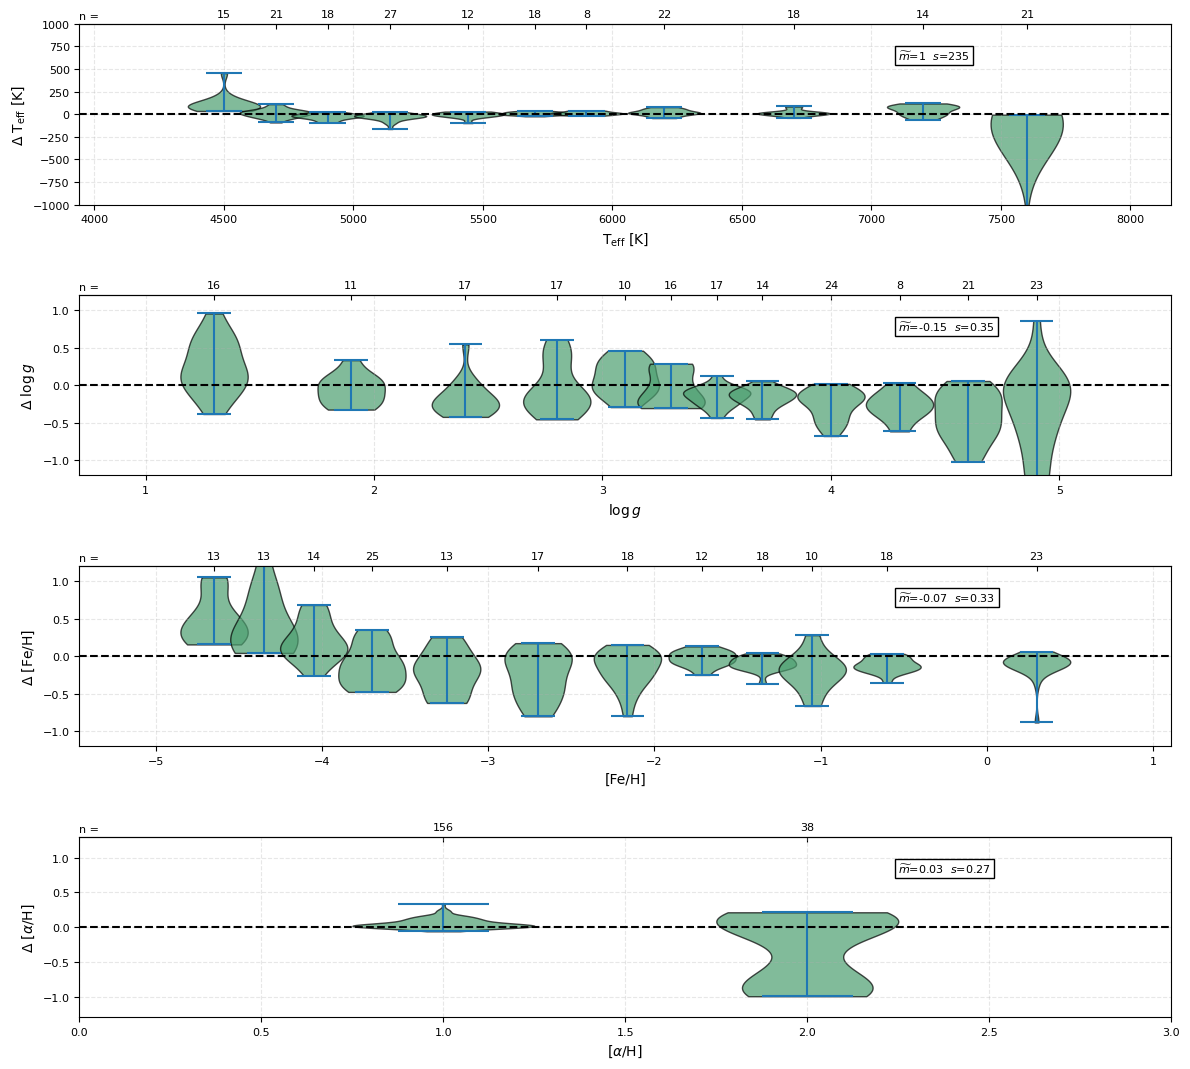

In [27]:
# Binned residual-violin plotting utility (ready to run)
# Default parameter names & mapping from short keys to column indices
param_names_default = ['Teff (K)', 'logg', '[Fe/H]', '[a/Fe]']
label_key_to_idx = {'teff': 0, 'logg': 1, 'feh': 2, 'alpha': 3}

def plot_resid_violin_binned(label_keys=None,
                             preds=None,
                             truths=None,
                             n_bins=10,
                             bin_method='quantile',   # 'quantile' or 'linear'
                             min_count=5,
                             y_lims=None,
                             savename=None,
                             figsize_per_row=2.7):
    """
    Make binned violin plots of residuals (pred - truth) for each requested label.
    - label_keys: list like ['teff','logg','feh','alpha'] or None to use all defaults
    - preds, truths: numpy arrays shape (N, n_params). If None, uses globals 'preds' and 'truths'.
    - n_bins: number of bins along the target domain (if domain has <= n_bins unique values, uses those unique values)
    - bin_method: 'quantile' (equal-count bins) or 'linear' (equal-width bins)
    - min_count: minimum samples in a bin to include it in the plot
    - y_lims: list/tuple of per-parameter +/- y-limits (optional). If None, computed automatically per parameter
    - savename: optional path to save the figure
    """
    # grab preds/truths from globals if not provided
    preds = preds if preds is not None else globals().get('preds', None)
    truths = truths if truths is not None else globals().get('truths', None)
    if preds is None or truths is None:
        raise RuntimeError("preds and truths not found: pass them or run evaluation cell first.")

    preds = np.asarray(preds)
    truths = np.asarray(truths)
    if preds.shape != truths.shape:
        raise RuntimeError(f"preds and truths must have same shape, got {preds.shape} vs {truths.shape}")

    n_params = preds.shape[1]
    if label_keys is None:
        # default order: teff, logg, feh, alpha (truncate to available params)
        label_keys = ['teff','logg','feh','alpha'][:n_params]

    # prepare figure
    n_plots = len(label_keys)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots * figsize_per_row), squeeze=False)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)

    for i, key in enumerate(label_keys):
        ax = axes[i,0]
        idx = label_key_to_idx.get(key, None)
        if idx is None or idx >= n_params:
            raise KeyError(f"Unknown or out-of-range label key '{key}' (requested index {idx})")

        pretty_name = key
        if key == 'teff':
            pretty_name = 'T$_{\\mathrm{eff}}$ [K]'
        elif key == 'feh':
            pretty_name = '[Fe/H]'
        elif key == 'logg':
            pretty_name = '$\\log{g}$'
        elif key == 'alpha':
            pretty_name = r'[$\alpha$/H]'

        tgt_vals = truths[:, idx]
        diff = preds[:, idx] - truths[:, idx]

        # Choose bin edges
        unique_vals = np.unique(tgt_vals)
        if unique_vals.size <= n_bins:
            # use exact unique values as "bins"
            bin_centers = unique_vals
            box_data = []
            box_positions = []
            for val in bin_centers:
                sel = np.where(tgt_vals == val)[0]
                if len(sel) >= min_count:
                    box_positions.append(val)
                    box_data.append(diff[sel])
            if len(box_positions) == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            box_positions = np.array(box_positions)
            box_width = np.mean(np.diff(np.sort(box_positions))) / 2 if box_positions.size>1 else 0.5
        else:
            # regular binning
            if bin_method == 'quantile':
                quantiles = np.linspace(0, 1, n_bins + 1)
                edges = np.unique(np.quantile(tgt_vals, quantiles))
                # if edges collapsed because of duplicates, fallback to linear
                if len(edges) <= 2:
                    edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)
            else:
                edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)

            box_positions = []
            box_data = []
            for j in range(len(edges)-1):
                low, high = edges[j], edges[j+1]
                if j == len(edges)-2:
                    # include rightmost edge
                    sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
                else:
                    sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
                if len(sel) >= min_count:
                    center = (low + high) / 2.0
                    box_positions.append(center)
                    box_data.append(diff[sel])
            box_positions = np.array(box_positions)
            if box_positions.size == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            # choose a sensible width
            if box_positions.size > 1:
                spacing = np.mean(np.diff(np.sort(box_positions)))
                box_width = spacing * 0.9
            else:
                # single bin
                span = (edges[-1] - edges[0]) if edges is not None else 1.0
                box_width = span * 0.2

        # Plot violins
        parts = ax.violinplot(box_data, positions=box_positions, widths=box_width,
                              showextrema=True, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor('#4C9F70')
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # Annotate median and standard deviation of residuals (global for that parameter)
        med = np.median(diff)
        std_ = np.std(diff)
        if 'eff' in pretty_name:
            ann = '$\\widetilde{m}$=%0.0f  $s$=%0.0f' % (med, std_)
        elif 'rad' in pretty_name:
            ann = '$\\widetilde{m}$=%0.1f  $s$=%0.1f' % (med, std_)
        else:
            ann = '$\\widetilde{m}$=%0.2f  $s$=%0.2f' % (med, std_)
        ax.annotate(ann, (0.75, 0.8), size=8, xycoords='axes fraction', bbox=bbox_props)

        # Axes labels, grid, zero line
        ax.set_xlabel(f'{pretty_name}')
        ax.set_ylabel(r'$\Delta$ %s' % pretty_name)
        ax.axhline(0, linewidth=1.5, c='black', linestyle='--')

        # y-limits
        if y_lims is not None:
            # if y_lims provided as list per param, pick ith or scalar
            if isinstance(y_lims, (list, tuple, np.ndarray)):
                if len(y_lims) >= len(label_keys):
                    yl = y_lims[i]
                else:
                    yl = y_lims[0]
            else:
                yl = y_lims
            ax.set_ylim(-yl, yl)
        else:
            # auto compute: a few times the median absolute deviation / percentile
            rng = np.percentile(np.abs(diff), 98)
            yl = max(rng * 1.2, np.std(diff) * 3, 1e-8)
            ax.set_ylim(-yl, yl)

        # x-limits & ticks
        ax.set_xlim(np.min(box_positions) - box_width*2, np.max(box_positions) + box_width*2)
        ax.tick_params(labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)

        # Annotate sample size of each bin on top as ticklabels
        ax.text(box_positions[0] - 2*box_width, 1.05 * ax.get_ylim()[1], 'n = ', fontsize=8)
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(box_positions)
        ax_t.set_xticklabels([len(d) for d in box_data])
        ax_t.tick_params(axis='x', direction='in', labelsize=8)

        # If Teff, set integer ticks
        if key == 'teff':
            tick_positions = ax.get_xticks()
            ax.set_xticklabels([int(x) for x in tick_positions])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)

    if savename is not None:
        path = Path(savename)
        fig.savefig(path, facecolor='white', transparent=False, dpi=150, bbox_inches='tight', pad_inches=0.05)
        print(f"Saved figure to {path}")

    plt.show()


# Example call using globals 'preds' and 'truths' computed earlier
# Default: 10 quantile bins, require at least 5 samples per bin
plot_resid_violin_binned(label_keys=['teff','logg','feh','alpha'],
                         preds=globals().get('preds'),
                         truths=globals().get('truths'),
                         n_bins=12,
                         bin_method='quantile',
                         min_count=1,
                         y_lims=[1000, 1.2, 1.2, 1.3])

In [28]:
# pick alpha index used by your plotting (same as label_key_to_idx['alpha'])
idx = 3
tgt_vals = globals().get('truths')[:, idx]            # shape (N,)
diff = globals().get('preds')[:, idx] - tgt_vals

print("N samples:", tgt_vals.size)
print("min, max:", tgt_vals.min(), tgt_vals.max())
print("unique count:", np.unique(tgt_vals).size)
vals, counts = np.unique(tgt_vals, return_counts=True)
print("top unique values (value:count):", list(zip(vals[:12], counts[:12]))[:12])

# quantile edges
n_bins=12
quantiles = np.linspace(0,1,n_bins+1)
q_edges = np.unique(np.quantile(tgt_vals, quantiles))
print("quantile edges (unique):", q_edges)
# show counts per quantile bin
import math
edges = np.quantile(tgt_vals, quantiles)
counts_q = []
for j in range(len(edges)-1):
    low, high = edges[j], edges[j+1]
    if j == len(edges)-2:
        sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
    else:
        sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
    counts_q.append(len(sel))
print("quantile bin counts (first 20):", counts_q[:20])
print("quantile bins with >=min_count:", sum(1 for c in counts_q if c>=3))

# linear edges
edges_lin = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins+1)
counts_lin = []
for j in range(len(edges_lin)-1):
    low, high = edges_lin[j], edges_lin[j+1]
    if j == len(edges_lin)-2:
        sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
    else:
        sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
    counts_lin.append(len(sel))
print("linear bin counts (first 20):", counts_lin[:20])
print("linear bins with >=min_count:", sum(1 for c in counts_lin if c>=3))

N samples: 194
min, max: 1.0 2.0
unique count: 2
top unique values (value:count): [(np.float32(1.0), np.int64(156)), (np.float32(2.0), np.int64(38))]
quantile edges (unique): [1. 2.]
quantile bin counts (first 20): [0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 0, 38]
quantile bins with >=min_count: 2
linear bin counts (first 20): [156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38]
linear bins with >=min_count: 2


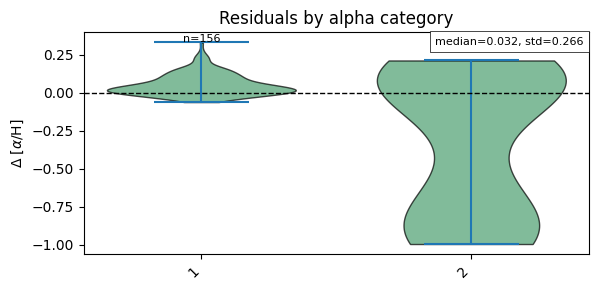

In [30]:
# Categorical violin plot helper for low-unique target columns (e.g. [alpha/H])
def plot_resid_categorical(label_key='alpha', preds=None, truths=None, min_count=1,
                           figsize=(6,3), savename=None):
    """
    Plot one violin per unique target value for a requested label.
    - label_key: one of 'teff','logg','feh','alpha'.
    - preds, truths: numpy arrays (N, n_params) or taken from globals if None.
    - min_count: minimum samples in a category to include it.
    """
    # use globals if not provided
    preds = preds if preds is not None else globals().get('preds')
    truths = truths if truths is not None else globals().get('truths')
    if preds is None or truths is None:
        raise RuntimeError("preds and truths not found - run the evaluation cell first.")

    preds = np.asarray(preds)
    truths = np.asarray(truths)
    if preds.shape != truths.shape:
        raise RuntimeError(f"preds and truths shape mismatch: {preds.shape} vs {truths.shape}")

    # mapping must match the notebook's mapping
    label_key_to_idx = {'teff': 0, 'logg': 1, 'feh': 2, 'alpha': 3}
    if label_key not in label_key_to_idx:
        raise KeyError(f"Unknown label_key '{label_key}'")
    idx = label_key_to_idx[label_key]
    if idx >= preds.shape[1]:
        raise RuntimeError(f"Requested label index {idx} out of range for preds with shape {preds.shape}")

    tgt_vals = truths[:, idx]
    diff = preds[:, idx] - truths[:, idx]

    # unique categories and counts
    vals, counts = np.unique(tgt_vals, return_counts=True)
    order = np.argsort(vals)
    vals = vals[order]
    counts = counts[order]

    # keep categories with at least min_count samples
    keep_mask = counts >= min_count
    vals_keep = vals[keep_mask]
    counts_keep = counts[keep_mask]
    if vals_keep.size == 0:
        raise RuntimeError(f"No categories with >= {min_count} samples for label '{label_key}'")

    groups = [diff[tgt_vals == v] for v in vals_keep]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(max(figsize[0], 0.8 * len(vals_keep)), figsize[1]))
    positions = np.arange(len(vals_keep))
    parts = ax.violinplot(groups, positions=positions, widths=0.7, showextrema=True, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor('#4C9F70')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    if 'cmedians' in parts:
        parts['cmedians'].set_color('black')

    # xticks as the raw category values (format nicely)
    xt_labels = [f"{v:.3g}" for v in vals_keep]
    ax.set_xticks(positions)
    ax.set_xticklabels(xt_labels, rotation=45, ha='right')

    # annotate counts above each violin
    ytop = ax.get_ylim()[1]
    for pos, cnt in zip(positions, counts_keep):
        ax.text(pos, ytop * 0.98, f"n={int(cnt)}", ha='center', va='top', fontsize=8)

    # annotate global median/std of residuals
    med = np.median(diff)
    std_ = np.std(diff)
    ax.annotate(f"median={med:0.3f}, std={std_:0.3f}", (0.99, 0.98), xycoords='axes fraction',
                ha='right', va='top', fontsize=8, bbox=dict(fc='white', ec='k', lw=0.5))

    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    pretty = {'teff':'T$_{\\mathrm{eff}}$', 'feh':'[Fe/H]', 'logg':'$\\log g$', 'alpha':'[$\\alpha$/H]'}
    lbl = pretty.get(label_key, label_key)
    ax.set_ylabel(r'$\Delta$ %s' % lbl)
    ax.set_title(f"Residuals by {label_key} category")
    plt.tight_layout()

    if savename is not None:
        path = Path(savename)
        fig.savefig(path, dpi=150, bbox_inches='tight')
        print(f"Saved categorical violin figure to {path}")

    plt.show()

# Example calls (run after evaluation cell):
# 1) Plot alpha categories (recommended for your data where unique count = 2):
plot_resid_categorical('alpha', min_count=1)

# 2) Loop over all labels if needed:
# for lk in ['teff','logg','feh','alpha'][:preds.shape[1]]:
#     plot_resid_categorical(lk, min_count=1, figsize=(6,3))

In [ ]:
# Path to the .npz history file - edit this if needed
HISTORY_PATH = Path('../pytorch_models/mlp_model.history.npz')

if not HISTORY_PATH.exists():
    raise FileNotFoundError(f'History file not found: {HISTORY_PATH}')

data = np.load(HISTORY_PATH, allow_pickle=True)
print('Loaded keys:', list(data.keys()))

train_loss = data['train_loss']
val_loss = data['val_loss']

print(f'train_loss shape: {train_loss.shape}')
print(f'val_loss shape: {val_loss.shape}')